
Time Sequence Prediction with Orthogonality Constrained LSTM
===============
In this part, we consider a toy example of RNN. Two LSTMCell units are used in this example to learn some sine wave signals starting at different phases. After learning the sine waves, the network tries to predict the signal values in the future. The results is shown in the picture below. 

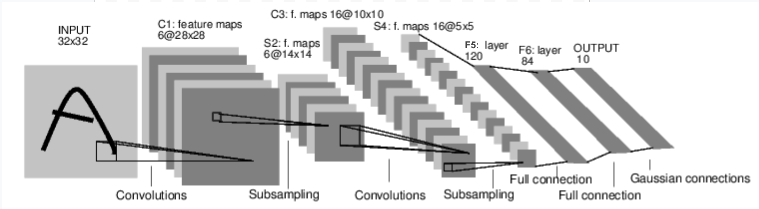

## Import modules

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cdopt
from cdopt.nn import LSTMCell_cdopt, get_quad_penalty


## Generate data

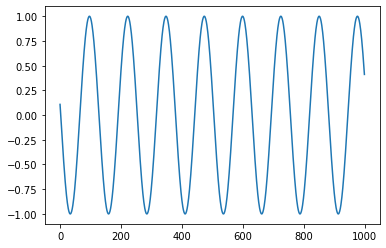

In [2]:
np.random.seed(2)

T = 20   # frequency of sine function
L = 1000 # length of datas
N = 100  # number of samples

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
# torch.save(data, open('traindata.pt', 'wb'))
plt.plot(data[0,:])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define the model

In [3]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = LSTMCell_cdopt(1, 51, manifold_class=cdopt.manifold_torch.stiefel_torch, penalty_param=0.01)
        self.lstm2 = LSTMCell_cdopt(51, 51, manifold_class=cdopt.manifold_torch.stiefel_torch, penalty_param=0.01)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).to(device)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

## Train the network 

In [4]:
total_steps = 15

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
# data = torch.load('traindata.pt')
input = torch.from_numpy(data[5:, :-1]).to(device)
target = torch.from_numpy(data[5:, 1:]).to(device)
test_input = torch.from_numpy(data[:5, :-1]).to(device)
test_target = torch.from_numpy(data[:5, 1:]).to(device)
# build the model
seq = Sequence()
seq.double()
seq.to(device)
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train

y_total = []

for i in range(total_steps):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target) + get_quad_penalty(seq)
        # print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target) 
        print('test loss:', loss.item())
        y = pred.detach().cpu().numpy()
        y_total.append(y)


STEP:  0
test loss: 0.0025251951578140457
STEP:  1
test loss: 0.00025660020731900035
STEP:  2
test loss: 8.681696566244564e-05
STEP:  3
test loss: 5.840881977934534e-05
STEP:  4
test loss: 3.332488872820001e-05
STEP:  5
test loss: 2.3754566930174518e-05
STEP:  6
test loss: 1.4184226204232922e-05
STEP:  7
test loss: 1.0058119918238999e-05
STEP:  8
test loss: 8.268337222432896e-06
STEP:  9
test loss: 6.963616237926994e-06
STEP:  10
test loss: 6.238348566216735e-06
STEP:  11
test loss: 5.715138274274241e-06
STEP:  12
test loss: 5.429011606623634e-06
STEP:  13
test loss: 5.357872138363362e-06
STEP:  14
test loss: 5.357872138363362e-06


We can observe that the weights in `seq.lstm1` and `seq.lstm2` are nearly feasible.

In [5]:
seq.lstm1.quad_penalty() + seq.lstm2.quad_penalty()

tensor(4.4976e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)

## Plot results

We then plot the results of the prediction. We first plot the prediction result in the first round of the trainning. 

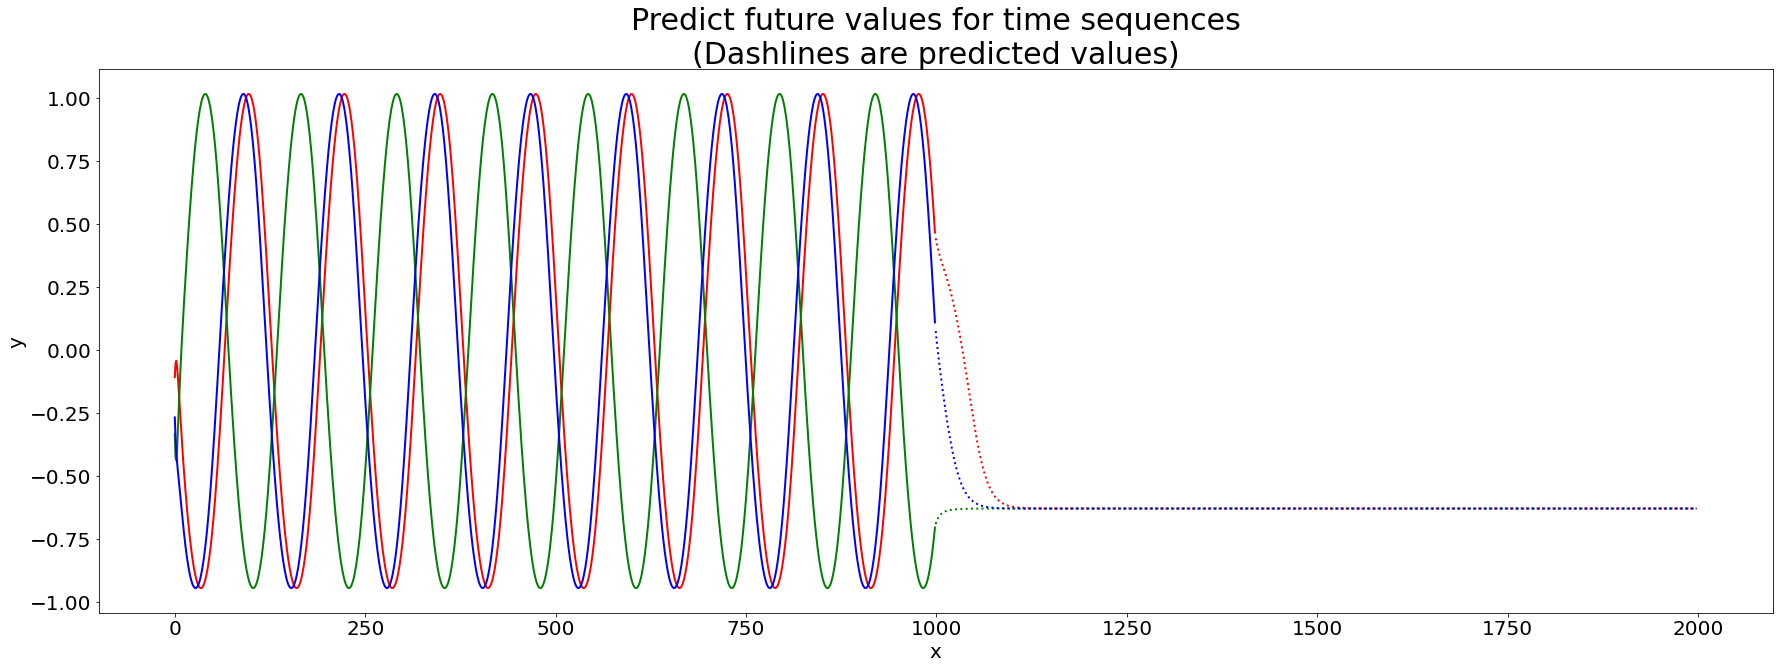

In [6]:
# draw the result
y = y_total[0]
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
plt.show()
plt.close()

Then we plot the results at the 5-th round. 

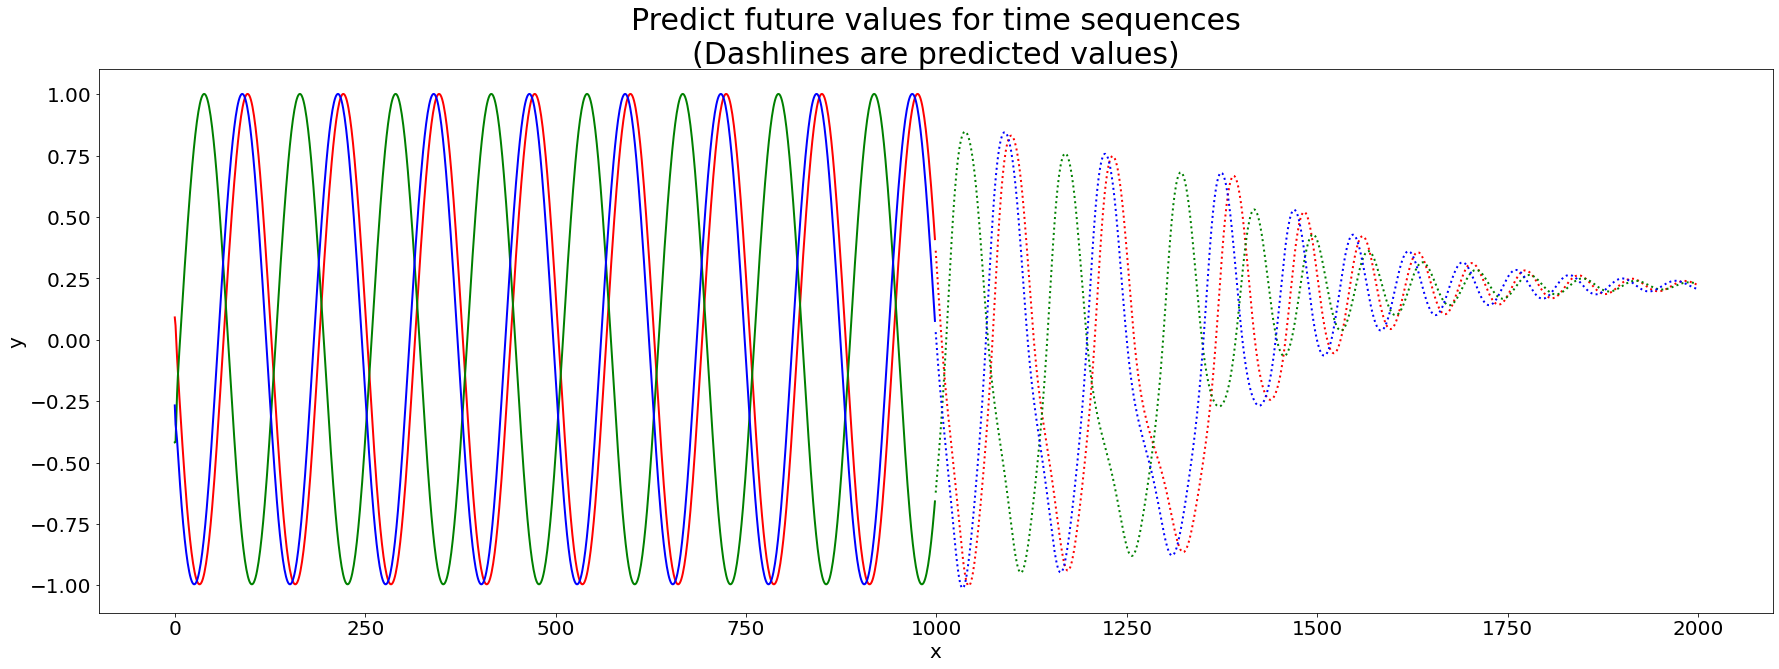

In [7]:
# draw the result
y = y_total[5]
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
plt.show()
plt.close()

Finally, we plot the final prediction result. 

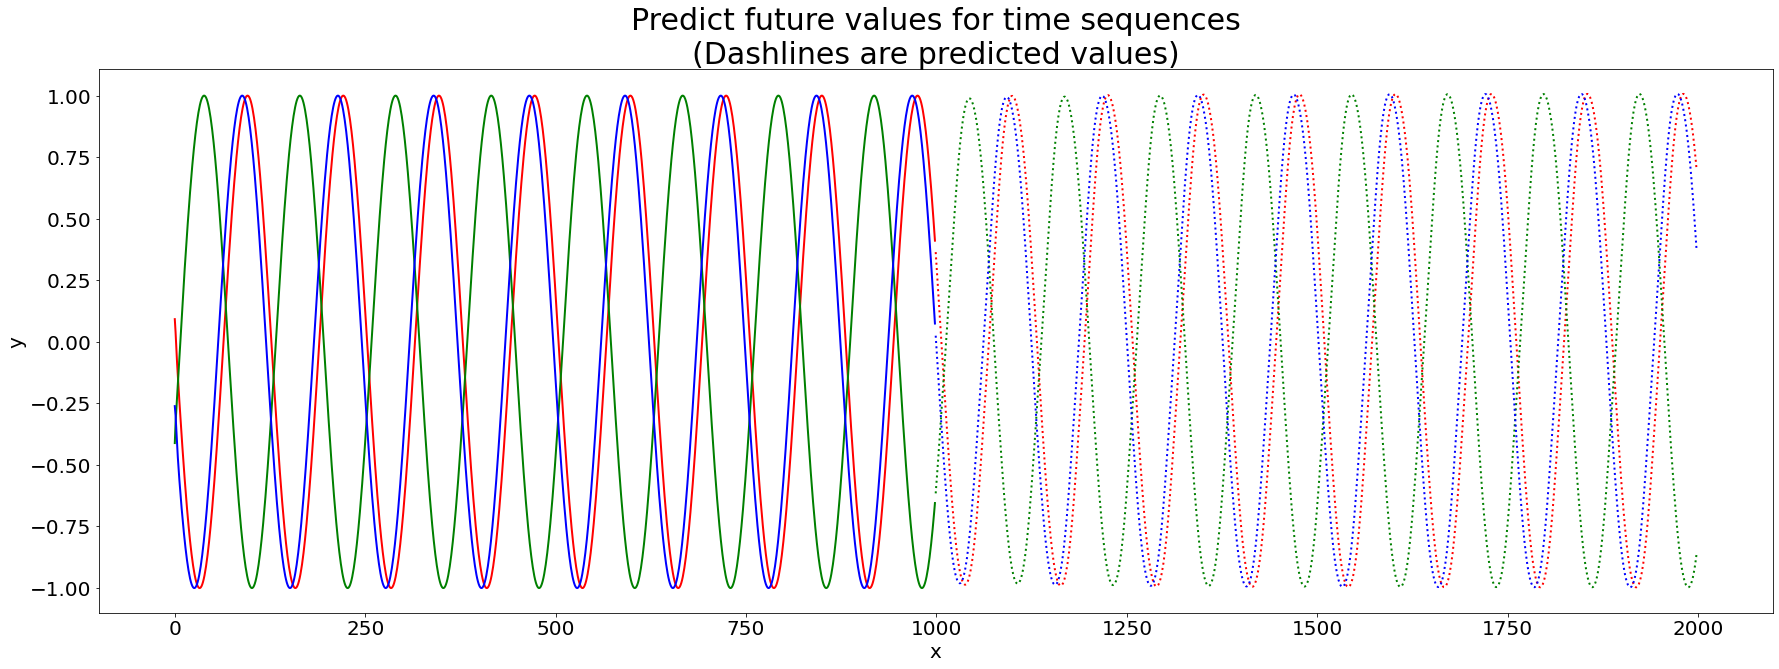

In [8]:
# draw the result
y = y_total[-1]
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
plt.show()
plt.close()

## Reference
1. https://github.com/pytorch/examples/tree/main/time_sequence_prediction
2. Hu X, Xiao N, Liu X, Toh KC. A Constraint Dissolving Approach for Nonsmooth Optimization over the Stiefel Manifold[J]. arXiv preprint arXiv:2205.10500, 2022.